# The connection between public record and loan performance

## Excutive Summary

### Goal

### Background


## Analysis

### Data
#### Public Records

There are 14 columns in this dataset. The descriptions for each columns are as follows:

Analytics Matchkey(analytics_matchkey): Unique customer identifier

Industry Code (Kind of Business, industry_code_kind_of_business): A code used to categorize subscribers by their primary line of business (e.g. A=Automotive, B=Banks and S&Ls).  The second position of the code further describes kind of business. 

Reporting Subscriber Code(reporting_subscriber_code): Internal trade line identifier.  The first 4 bytes are the base code, the last 3 bytes are the suffix.

Public Record Type Code(public_record_type_code): Identifies the type of public record.  

Effective Date (Date Verified, effective_date_date_verified): Date when the Reporting Subscriber took cognizance of the Record in its files.

Filed Date(filed_date): Date when the Record became officially public.

Paid Date(paid_date): Displays the date the subject paid the assessed amount.

Amount(amount): Displays the original amount in the case.

Public Record Source Type Code(public_record_source_type_code): Identifies the source (court) of this case information.  

Equal Credit Opportunity Act Code(equal_credit_opportunity_act_code): Displays the contractual ownership of the public record.  

Legislative Prohibited Code(legislative_prohibited_code): Identifies if the account is Medical related.   

Plaintiff Name: Plaintiff Name

Attorney Name: Attorney Name

Docket Number: Docket Number


#### Loan Performance

There are 5 columns in this dataset. The descriptions for each columns are as follows:

Analytics Matchkey: Unique customer identifier

Max Loan Amount: The amount of the loan given

Late 30 Days: Indicates if a loan was ever delinquent by at least 30 days in 24 months.

Late 60 Days: Indicates if a loan was ever delinquent by at least 60 days in 24 months.

Late 90 Days: Indicates if a loan was ever delinquent by at least 90 days in 24 months.

### Methdology

## Findings

### Final results

### Future works

### Recommendations

## Analysis Process

### Exploratory Data Analysis

According to the rudimentary exploration on the whole dataset:

1. 1 unique identifier for customer: there are 83586 repeated analytics_matchkey's, which means there are some customers who have more than 1 loan with our company.

2. 6 categorical columns:'industry_code_kind_of_business','reporting_subscriber_code', 'public_record_type_code', 'public_record_source_type_code', 'equal_credit_opportunity_act_code', 'legislative_prohibited_code'. I might not change the data types of these columns since this wouldn't affect my analysis. For 'public_record_type_code' I am going to bin together the classes whose sizes are too small(less than 30).

3. 1 numerical columns: 'amount'

4. 3 datetime columns: 'effective_date_date_verified','filed_date', 'paid_date'. I might consider binning these variables to make the trend more noticeable.

5. 3 columns 'plaintiff_name', 'attorney_name','docket_number' contain no information and these columns will be removed.

6. columns 'effective_date_date_verified', 'paid_date','amount','public_record_source_type_code' have missing data. Among these columns, there is only 1 missing value in 'public_record_source_type_code', it is very likely that this can be a typo. For the datetime columns, I will create binary variables indicating if a given loan went through a certain step(filed/paid/verified). For the missing value in 'public_record_source_type_code', I might just leave it there.

7. By now, about 60% of loans have paid the assessed amount.

8. More than 70% of loans have the information of the original amount in the case.

In [1]:
%matplotlib inline
import random
import pandas as pd
import numpy as np
import scipy.stats as st
from datetime import date, timedelta


import pdpbox
from pdpbox import pdp
from pdpbox.info_plots import target_plot
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.tree.export import export_text
from sklearn.tree import plot_tree
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
publicRecords = pd.read_csv('Public_records.csv',parse_dates=['effective_date_date_verified',
                                                    'filed_date',
                                                    'paid_date'])

In [3]:
publicRecords.head()

,analytics_matchkey,industry_code_kind_of_business,reporting_subscriber_code,public_record_type_code,effective_date_date_verified,filed_date,paid_date,amount,public_record_source_type_code,equal_credit_opportunity_act_code,legislative_prohibited_code,plaintiff_name,attorney_name,docket_number
0,1346747,ZP,99,CJ,2013-06-04,2013-01-29,NaT,1209.0,CI,I,1,NaN,NaN,NaN
1,1346748,ZP,485,7X,2014-09-25,2014-05-06,2014-09-24,NaN,FE,I,1,NaN,NaN,NaN
2,1346754,Z,11R,SL,2012-01-24,2011-04-05,NaT,2248.0,RD,I,1,NaN,NaN,NaN
3,1346754,ZP,1,7X,2013-01-29,2012-09-28,2013-01-28,NaN,FE,C,1,NaN,NaN,NaN
4,1346756,ZP,1,RL,2014-09-13,2007-02-02,2014-08-01,406.0,RD,I,1,NaN,NaN,NaN


In [4]:
publicRecords.describe().round()

,analytics_matchkey,amount,legislative_prohibited_code,plaintiff_name,attorney_name,docket_number
count,218303.0,156792.0,218303.0,0.0,0.0,0.0
mean,1669627.0,4617.0,1.0,NaN,NaN,NaN
std,186294.0,41801.0,0.0,NaN,NaN,NaN
min,1346747.0,0.0,1.0,NaN,NaN,NaN
25%,1508168.0,644.0,1.0,NaN,NaN,NaN
50%,1669451.0,1338.0,1.0,NaN,NaN,NaN
75%,1831498.0,3174.0,1.0,NaN,NaN,NaN
max,1992902.0,9999999.0,2.0,NaN,NaN,NaN


In [5]:
publicRecords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218303 entries, 0 to 218302
Data columns (total 14 columns):
analytics_matchkey                   218303 non-null int64
industry_code_kind_of_business       218303 non-null object
reporting_subscriber_code            218303 non-null object
public_record_type_code              218303 non-null object
effective_date_date_verified         218018 non-null datetime64[ns]
filed_date                           218303 non-null datetime64[ns]
paid_date                            129421 non-null datetime64[ns]
amount                               156792 non-null float64
public_record_source_type_code       218302 non-null object
equal_credit_opportunity_act_code    218303 non-null object
legislative_prohibited_code          218303 non-null int64
plaintiff_name                       0 non-null float64
attorney_name                        0 non-null float64
docket_number                        0 non-null float64
dtypes: datetime64[ns](3), float64(4),

In [6]:
# check the proportion of loans have information of 'paid_date'(paid the assessed amount)
print(round(129421/218303,2),'of loans have paid the assessed amount.')
# check the proportion of loans have information of 'amount'(the original amount in the case)
print(round(156792/218303,2),'of loans have the information of the original amount in the case.')

0.59 of loans have paid the assessed amount.
0.72 of loans have the information of the original amount in the case.


In [7]:
# check whether 'analytics_matchkey' is unique
publicRecords.shape[0] - len(set(publicRecords['analytics_matchkey']))

83586

In [8]:
# drop the columnns: 'plaintiff_name','attorney_name','docket_number'
publicRecords = publicRecords.drop(['plaintiff_name','attorney_name','docket_number'], axis=1)

In [9]:
# check the distribution of categorial variables:
# 'industry_code_kind_of_business'
# 'reporting_subscriber_code'           
# 'public_record_type_code'              
print(publicRecords['industry_code_kind_of_business'].value_counts())
print(publicRecords['reporting_subscriber_code'].value_counts())
print(publicRecords['public_record_type_code'].value_counts())

ZP    198571
Z      19732
Name: industry_code_kind_of_business, dtype: int64
1      6075
203    2533
82     2502
3      2454
2      2356
       ... 
656       1
17Z       1
62N       1
988       1
12K       1
Name: reporting_subscriber_code, Length: 1535, dtype: int64
CJ    61425
7X    49842
PC    30449
RL    20099
SL    16205
CB    10266
FT     6511
PL     6172
3D     4356
PF     3591
3X     3500
3F     2184
TL     1764
7D     1109
7F      487
CP      301
1D       14
1X       11
TB        9
2X        3
2F        2
2D        2
1F        1
Name: public_record_type_code, dtype: int64


In [10]:
# bin public_record_type_code: If there are less than 30 examples in a class
to_replace_rsc = pd.DataFrame(publicRecords['public_record_type_code'].value_counts())
to_replace_rs_list = to_replace_rsc[to_replace_rsc['public_record_type_code']<30].index.to_list()
def rep_PRTC(x):
    if x in to_replace_rs_list:
        return 'other'
    else: return x
publicRecords['public_record_type_code_bin'] = publicRecords['public_record_type_code'].map(rep_PRTC)

#### Hypothesis 1: The working process: filed_date => paid_date => effective_date_date_verified? 

Based on the distribution of difference between paid_date, filed_date and effective_date_date_verified, I have the following findings:

1. Mostly(more than 93%), the whole process is that the loan is firstly get filed, then paid(if needed), then verified. The first step must be filing. Very rarely, verification happens before the corresponding payment. 

2. The time interval between filed date and paid date(if there is) tends to be around 1 year and it varies a lot. It took 60-119 days for more than 35% of loans to be paid after it was filed. More than 30% of loans took 119-475 days. More than 12% of loans took 475-950 days. More than 10% of loans took 950-1900 days. 

2. The time interval between paid date(if there is) and effective date tends to less than 50 days, including the situation that effective date happens before its payment, and 50% of loans only took 0-4 days to be verified after it was paid. The range of this intervel is from -2355 days to 3202 days. 

In [11]:
# sub-hypothesis:
# filed_date is always earlier than paid_date, if there is a paid_date for the given loan
n_paid_date = publicRecords[~publicRecords['paid_date'].isna()].shape[0]
n_filed_date = publicRecords[~publicRecords['filed_date'].isna()].shape[0]
print(round(sum(publicRecords['filed_date']<publicRecords['paid_date'])/n_paid_date,4),'of the records with a paid_date, the filed_date happens before paid_date.')
print(round(sum(publicRecords['filed_date']==publicRecords['paid_date'])/n_paid_date,4),'of the records with a paid_date, the filed_date happen on the same day as paid_date.')
print(round(sum(publicRecords['filed_date']>publicRecords['paid_date'])/n_paid_date,4),'of the records with a paid_date, the filed_date happens after paid_date.')

0.9972 of the records with a paid_date, the filed_date happens before paid_date.
0.0028 of the records with a paid_date, the filed_date happen on the same day as paid_date.
0.0 of the records with a paid_date, the filed_date happens after paid_date.


In [12]:
# sub-hypothesis:
# paid_date is always earlier than effective_date_date_verified, if there is a paid_date for the given loan
print(round(sum(publicRecords['paid_date']<publicRecords['effective_date_date_verified'])/n_paid_date,4),'of the records with a paid_date, the paid_date happens before effective_date_date_verified.')
print(round(sum(publicRecords['paid_date']==publicRecords['effective_date_date_verified'])/n_paid_date,4),'of the records with a paid_date, the paid_date happens on the same day as effective_date_date_verified.')
print(round(sum(publicRecords['paid_date']>publicRecords['effective_date_date_verified'])/n_paid_date,4),'of the records with a paid_date, the paid_date happens after effective_date_date_verified.')

0.9313 of the records with a paid_date, the paid_date happens before effective_date_date_verified.
0.0004 of the records with a paid_date, the paid_date happens on the same day as effective_date_date_verified.
0.0681 of the records with a paid_date, the paid_date happens after effective_date_date_verified.


In [13]:
# sub-hypothesis:
# filed_date is always earlier than effective_date_date_verified, if there is a filed_date for the given loan
print(round(sum(publicRecords['filed_date']<publicRecords['effective_date_date_verified'])/n_filed_date ,4),'of the records with a filed_date , the filed_date happens before effective_date_date_verified.')
print(round(sum(publicRecords['filed_date']==publicRecords['effective_date_date_verified'])/n_filed_date ,4),'of the records with a filed_date, the filed_date happens on the same day as effective_date_date_verified.')
print(round(sum(publicRecords['filed_date']>publicRecords['effective_date_date_verified'])/n_filed_date ,4),'of the records with a filed_date, the filed_date happens after effective_date_date_verified.')

0.9951 of the records with a filed_date , the filed_date happens before effective_date_date_verified.
0.0036 of the records with a filed_date, the filed_date happens on the same day as effective_date_date_verified.
0.0 of the records with a filed_date, the filed_date happens after effective_date_date_verified.


In [14]:
publicRecords['diff_paid_filed'] = publicRecords['paid_date']-publicRecords['filed_date']
publicRecords['diff_effe_paid'] = publicRecords['effective_date_date_verified']-publicRecords['paid_date']

In [15]:
publicRecords['diff_paid_filed_int'] = publicRecords['diff_paid_filed']/np.timedelta64(1, 'D')
publicRecords['diff_effe_paid_int'] = publicRecords['diff_effe_paid']/np.timedelta64(1, 'D')
print(publicRecords['diff_paid_filed_int'].describe())
print(publicRecords['diff_effe_paid_int'].describe())

count    129421.000000
mean        380.077623
std         484.184294
min           0.000000
25%         100.000000
50%         139.000000
75%         461.000000
max        3793.000000
Name: diff_paid_filed_int, dtype: float64
count    129407.000000
mean         75.911774
std         358.554891
min       -2354.000000
25%           1.000000
50%           4.000000
75%          49.000000
max        3203.000000
Name: diff_effe_paid_int, dtype: float64


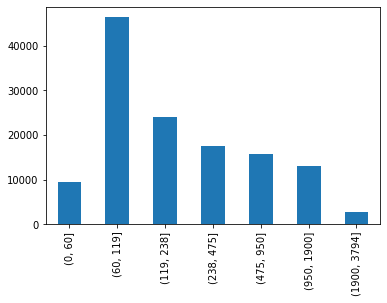

In [16]:
pd.cut(publicRecords[~publicRecords['diff_paid_filed_int'].isna()]['diff_paid_filed_int'], 
       bins=[0,60,119,238,475,950,1900,3794]).value_counts().sort_index().plot(kind='bar')

In [17]:
pd.cut(publicRecords[~publicRecords['diff_paid_filed_int'].isna()]['diff_paid_filed_int'], 
       bins=[0,60,119,238,475,950,1900,3794]).value_counts()/n_paid_date

(60, 119]       0.358033
(119, 238]      0.185889
(238, 475]      0.135589
(475, 950]      0.121734
(950, 1900]     0.100926
(0, 60]         0.073620
(1900, 3794]    0.021418
Name: diff_paid_filed_int, dtype: float64

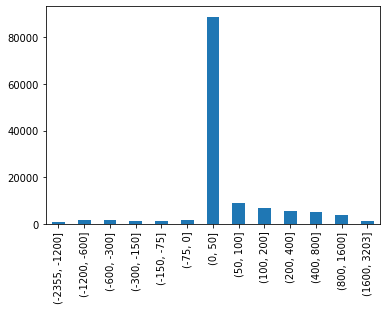

In [18]:
pd.cut(publicRecords[~publicRecords['diff_effe_paid_int'].isna()]['diff_effe_paid_int'], 
       bins=[-2355,-1200,-600,-300,-150,-75,0,50,100,200,400,800,1600,3203]).value_counts().sort_index().plot(kind='bar')

In [19]:
pd.cut(publicRecords[~publicRecords['diff_effe_paid_int'].isna()]['diff_effe_paid_int'], 
       bins=[-2355,-1200,-600,-300,-150,-75,0,50,100,200,400,800,1600,3203]).value_counts()/n_paid_date

(0, 50]           0.685638
(50, 100]         0.069131
(100, 200]        0.053593
(200, 400]        0.043733
(400, 800]        0.038665
(800, 1600]       0.029632
(-1200, -600]     0.014070
(-600, -300]      0.013661
(-75, 0]          0.012826
(-300, -150]      0.011142
(1600, 3203]      0.010941
(-150, -75]       0.010052
(-2355, -1200]    0.006807
Name: diff_effe_paid_int, dtype: float64

In [20]:
publicRecords[publicRecords['diff_effe_paid_int']<366]['diff_effe_paid_int'].count()/n_paid_date

0.9153151343290502

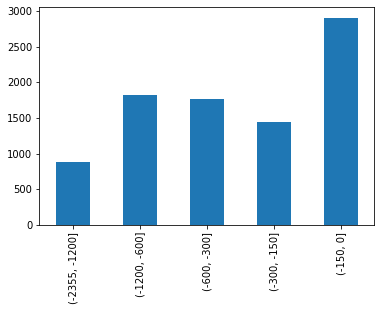

In [21]:
pd.cut(publicRecords[publicRecords['diff_effe_paid_int']<0]['diff_effe_paid_int'], 
       bins=[-2355,-1200,-600,-300,-150,0]).value_counts().sort_index().plot(kind='bar')

In [22]:
publicRecords['diff_paid_filed_bin'] = pd.cut(publicRecords['diff_paid_filed_int'], 
       bins=[0,60,119,238,475,950,3794])
publicRecords['diff_effe_paid_bin'] = pd.cut(publicRecords['diff_effe_paid_int'], 
       bins=[-2355,0,50,100,200,400,800,3203])

In [23]:
publicRecords.head(5)

,analytics_matchkey,industry_code_kind_of_business,reporting_subscriber_code,public_record_type_code,effective_date_date_verified,filed_date,paid_date,amount,public_record_source_type_code,equal_credit_opportunity_act_code,legislative_prohibited_code,public_record_type_code_bin,diff_paid_filed,diff_effe_paid,diff_paid_filed_int,diff_effe_paid_int,diff_paid_filed_bin,diff_effe_paid_bin
0,1346747,ZP,99,CJ,2013-06-04,2013-01-29,NaT,1209.0,CI,I,1,CJ,NaT,NaT,NaN,NaN,NaN,NaN
1,1346748,ZP,485,7X,2014-09-25,2014-05-06,2014-09-24,NaN,FE,I,1,7X,141 days,1 days,141.0,1.0,"(119.0, 238.0]","(0.0, 50.0]"
2,1346754,Z,11R,SL,2012-01-24,2011-04-05,NaT,2248.0,RD,I,1,SL,NaT,NaT,NaN,NaN,NaN,NaN
3,1346754,ZP,1,7X,2013-01-29,2012-09-28,2013-01-28,NaN,FE,C,1,7X,122 days,1 days,122.0,1.0,"(119.0, 238.0]","(0.0, 50.0]"
4,1346756,ZP,1,RL,2014-09-13,2007-02-02,2014-08-01,406.0,RD,I,1,RL,2737 days,43 days,2737.0,43.0,"(950.0, 3794.0]","(0.0, 50.0]"


In [27]:
def find_k(X):
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(X.reshape(-1,1))
        wcss.append(kmeans.inertia_)
    plt.plot(range(1, 11), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

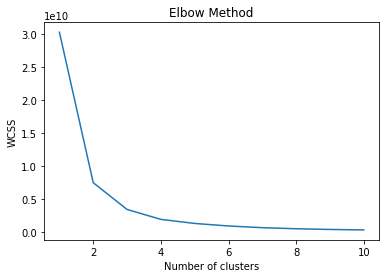

In [48]:
m_p_f = publicRecords[~publicRecords['diff_paid_filed_int'].isna()]
x_p_f = m_p_f['diff_paid_filed_int'].values
find_k(x_p_f)

In [61]:
kmeans_p_f = KMeans(n_clusters=3)
kmeans_p_f.fit(x_p_f.reshape(-1,1))
labels_p_f = kmeans_p_f.predict(x_p_f.reshape(-1,1))

In [62]:
m_p_f['diff_paid_filed_label'] = labels_p_f
print(m_p_f.groupby('diff_paid_filed_label')['diff_paid_filed_int'].min())
print(m_p_f.groupby('diff_paid_filed_label')['diff_paid_filed_int'].max())
print(m_p_f.groupby('diff_paid_filed_label')['diff_paid_filed_int'].count()/n_paid_date)

diff_paid_filed_label
0       0.0
1    1271.0
2     475.0
Name: diff_paid_filed_int, dtype: float64
diff_paid_filed_label
0     474.0
1    3793.0
2    1270.0
Name: diff_paid_filed_int, dtype: float64
diff_paid_filed_label
0    0.755519
1    0.074362
2    0.170119
Name: diff_paid_filed_int, dtype: float64


In [54]:
m_p_f['diff_paid_filed_label'] = m_p_f['diff_paid_filed_label'].replace(0,'[0,474]').replace(1,'[1271,3793]').replace(2,'[475,1270]')

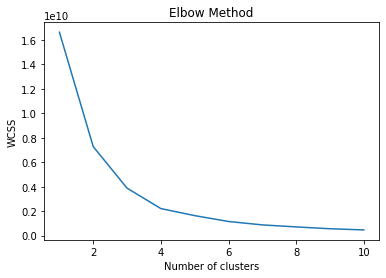

In [55]:
m_e_p = publicRecords[~publicRecords['diff_effe_paid_int'].isna()]
x_e_p = m_e_p['diff_effe_paid_int'].values
find_k(x_e_p)

In [65]:
kmeans_e_p = KMeans(n_clusters=4)
kmeans_e_p.fit(x_e_p.reshape(-1,1))
labels_e_p = kmeans_e_p.predict(x_e_p.reshape(-1,1))
m_e_p['diff_effe_paid_label'] = labels_e_p
print(m_e_p.groupby('diff_effe_paid_label')['diff_effe_paid_int'].min())
print(m_e_p.groupby('diff_effe_paid_label')['diff_effe_paid_int'].max())
print(m_e_p.groupby('diff_effe_paid_label')['diff_effe_paid_int'].count()/n_paid_date)

diff_effe_paid_label
0    -491.0
1    1129.0
2   -2354.0
3     320.0
Name: diff_effe_paid_int, dtype: float64
diff_effe_paid_label
0     319.0
1    3203.0
2    -492.0
3    1127.0
Name: diff_effe_paid_int, dtype: float64
diff_effe_paid_label
0    0.882052
1    0.024440
2    0.024818
3    0.068582
Name: diff_effe_paid_int, dtype: float64


In [66]:
m_e_p['diff_effe_paid_label'] = m_e_p['diff_effe_paid_label'].replace(
    2,'[-2354,-492]').replace(3,'[320,1127]').replace(0,'[-491,319]').replace(1,'[1129,3203]')

#### Hypothesis 2: ('amount')Original amount is not required for all/segmentation?

#### Hypothesis 3: The segmentation of Loans among the filed/ paid/ effective loans.

#### Hypothesis 4: The relationship beween the segmentations of Loans and amount.

#### Hypothesis X: By clustering the data, is there other trend/pattern?